# **Convolutional neural networks to recognize digits**

The project uses Convolutional Neural Networks to classify the Street View Housing Numbers (SVHN) image dataset for this project.

---
### **Context:** 
---

Deep learning can be applied to recognize objects in natural scenes. The ability to process visual information using machine learning algorithms can be very useful as demonstrated in various applications.

The SVHN dataset contains over 600,000 labeled digits cropped from street-level photos. It is one of the most popular image recognition datasets. It has been used in neural networks created by Google to improve map quality by automatically transcribing the address numbers from a patch of pixels. The transcribed number with a known street address helps pinpoint the location of the building it represents. 

---
### **Objective:**
---

Build a CNN model that can identify the digits in the images.

---
### **Dataset**
---

The data is part of a Kaggle competition and can be downloaded at: https://www.kaggle.com/stanfordu/street-view-house-numbers
Here, we will use a subset of the original data to save some computation time. The dataset is provided as a .h5 file. The basic preprocessing steps have been done.

## **Importing libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU
from tensorflow.keras.utils import to_categorical

Check for the version of TensorFlow.

In [3]:
print(tf.__version__)

2.8.0


## **Load the dataset**
- The dataset is a .h5 file (not available in the repo --> can be downloaded at https://www.kaggle.com/stanfordu/street-view-house-numbers)
- The data is split into train and the test to avoid overfit

In [43]:
import h5py

# Download data at: https://www.kaggle.com/stanfordu/street-view-house-numbers

# Open the file as read only
# User can make changes in the path as required

h5f = h5py.File('SVHN_single_grey1.h5', 'r')

# Print the keys
for key in h5f.keys():
    print(key) #Names of the groups in HDF5 file.

# Load the training and the test set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
X_val = h5f['X_val'][:]
y_val = h5f['y_val'][:]

# Close this file
h5f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
X_test
X_train
X_val
y_test
y_train
y_val


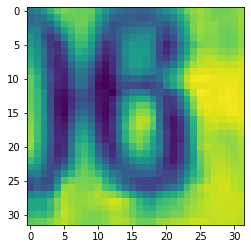

In [44]:
# Plot a random image for checking purposes
plt.imshow(X_train[np.random.randint(0,X_train.shape[0]-1),:,:])

In [45]:
# Check the number of images in the training and testing data.
len(X_train), len(X_test), len(X_val)

(42000, 18000, 60000)

**Observations**
- There are 42,000 images in the training data and 18,000 images in the testing data. 

## **Visualizing images**

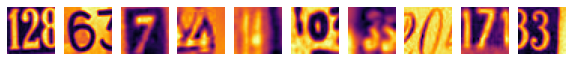

label for each of the above image: [2 6 7 4 4 0 3 0 7 3]


In [46]:
# visualizing the first 10 images in the dataset and their labels
plt.figure(figsize=(10, 1))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i], cmap="inferno") # write the function to visualize images
    plt.axis('off')

plt.show()
print('label for each of the above image: %s' % (y_train[0:10]))

## **Data Preparation**
The following steps are performed to prepare the data for the analyses:
- Check the shape of the images;
- Reshape the train and the test dataset to make them fit the first convolutional operation
- Normalize The train and the test dataset (dividing by 255)
- The target variable will be processed and tranformed into one-hot encode

In [47]:
# Shape of the images and the first image
print("Shape:", X_train[0].shape)
print()
print("First image:\n", X_train[0])

# Reshaping the dataset by flatten them. 4D array must be given as CNNs input
X_train = X_train.reshape(X_train.shape[0], 32,32,1)
X_test = X_test.reshape(X_test.shape[0], 32,32,1)

# Normalize inputs
X_train = X_train / 255.0
X_test = X_test / 255.0

# Check reshape 
print('Training set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

# One-hot encoding the output
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# Check the labels
print('Training label', y_train)
print('Testing label', y_test)

Shape: (32, 32)

First image:
 [[ 33.0704  30.2601  26.852  ...  71.4471  58.2204  42.9939]
 [ 25.2283  25.5533  29.9765 ... 113.0209 103.3639  84.2949]
 [ 26.2775  22.6137  40.4763 ... 113.3028 121.775  115.4228]
 ...
 [ 28.5502  36.212   45.0801 ...  24.1359  25.0927  26.0603]
 [ 38.4352  26.4733  23.2717 ...  28.1094  29.4683  30.0661]
 [ 50.2984  26.0773  24.0389 ...  49.6682  50.853   53.0377]]
Training set: (42000, 32, 32, 1) (42000,)
Test set: (18000, 32, 32, 1) (18000,)
Training label [[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Testing label [[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]]


## **CNN Model Building**

In [10]:
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

#Importing losses and optimizers modules
from tensorflow.keras import losses
from tensorflow.keras import optimizers

#Define the function to build model architecture
def cnn_model_1():
    model = Sequential() 
    #Add layers as per the architecture mentioned above in the same sequence
    model.add(Conv2D(filters=16, kernel_size=(3, 3), padding="same", input_shape=(32, 32, 1)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(LeakyReLU(0.1))
    model.add(Dense(10, activation='softmax'))

    #declare adam optimizer with learning rate of 0.001 
    adam = optimizers.Adamax(learning_rate=0.001)
    
    #compile the model
    model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

In [11]:
#Build the model
model_1 = cnn_model_1()

#Print the model summary
model_1.summary()

import pydot

#Build dot model to export
dot_mod = tf.keras.utils.model_to_dot(model_1,show_shapes=False,show_dtype=False,show_layer_names=False,rankdir="LR",expand_nested=False,dpi=96,subgraph=False,layer_range=None,show_layer_activations=False,)
#Export dot to png of CNN architecture
dot_mod.write_png('GraphCNN.png')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                        

True

In [12]:
# Fit the model
history_model_1 = model_1.fit(X_train,y_train,validation_split=0.2,batch_size=32,epochs=20,verbose=1)

Epoch 1/20
1050/1050 [==============================] - 23s 14ms/step - loss: 1.7238 - accuracy: 0.4384 - val_loss: 1.0959 - val_accuracy: 0.6763
Epoch 2/20
1050/1050 [==============================] - 12s 11ms/step - loss: 0.8502 - accuracy: 0.7550 - val_loss: 0.7191 - val_accuracy: 0.7981
Epoch 3/20
1050/1050 [==============================] - 12s 11ms/step - loss: 0.6511 - accuracy: 0.8115 - val_loss: 0.6441 - val_accuracy: 0.8175
Epoch 4/20
1050/1050 [==============================] - 11s 11ms/step - loss: 0.5739 - accuracy: 0.8352 - val_loss: 0.5866 - val_accuracy: 0.8320
Epoch 5/20
1050/1050 [==============================] - 10s 10ms/step - loss: 0.5315 - accuracy: 0.8477 - val_loss: 0.5827 - val_accuracy: 0.8387
Epoch 6/20
1050/1050 [==============================] - 10s 10ms/step - loss: 0.4951 - accuracy: 0.8594 - val_loss: 0.5708 - val_accuracy: 0.8355
Epoch 7/20
1050/1050 [==============================] - 11s 11ms/step - loss: 0.4733 - accuracy: 0.8644 - val_loss: 0.5205 -

### **Plotting the validation and training accuracies and losses**

In [25]:
#Plotting function for hisotry of CNN
def PlotMetricsCNN(Model, axis, *args):
  for i in args:
    axis.plot(Model.history[i], label=i)

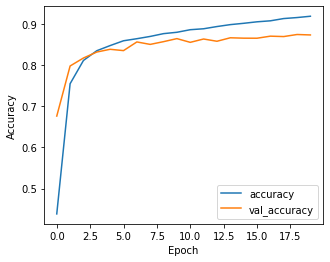

In [29]:
#Plot the accuracy
fig, ax = plt.subplots(1,1,figsize=(5,4))
PlotMetricsCNN(history_model_1, ax, 'accuracy', 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

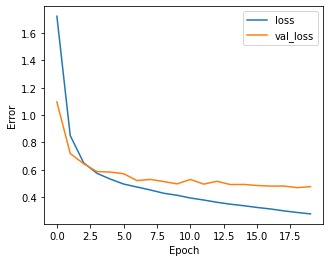

In [30]:
#Plot the loss
fig, ax = plt.subplots(1,1,figsize=(5,4))
PlotMetricsCNN(history_model_1, ax, 'loss', 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

**Observations:**
- The model slightly overfits the data (accuracy of validation $<$ accuracy of training);
- Overfit can be reduced by improving the model; 

Here, I build another model and to get a more generalized performance. First, the previous model's history is cleared from the keras backend.

In [31]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

### **Second Model Architecture**
Compared to the previous architecture, the new model has two additional convolutional layers that are followed each by a batch normalization layer placed after the max-pooling layer. Furthermore, a dropout layer with rate 0.5 is placed before the final softmax layer. The model is further trained for 30 epochs.

In [33]:
#Define the function
def cnn_model_2():
    model = Sequential() 
    #Add layers as per the architecture mentioned above in the same sequence
    model.add(Conv2D(filters=16, kernel_size=(3, 3), padding="same", input_shape=(32, 32, 1)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(32))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))   
    
    #declare adam optimizer with learning rate of 0.001 
    adam = optimizers.Adamax(learning_rate=0.001)
    
    #compile the model
    model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

# Build the model
model_2 = cnn_model_2()

#Print the summary
model_2.summary()

#Build dot model to export
dot_mod = tf.keras.utils.model_to_dot(model_2,show_shapes=False,show_dtype=False,show_layer_names=False,rankdir="LR",expand_nested=False,dpi=96,subgraph=False,layer_range=None,show_layer_activations=False,)
#Export dot to png of CNN architecture
dot_mod.write_png('GraphCNN_2.png')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 16)        160       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                      

True

In [34]:
# Fit the model
history_model_2 = model_2.fit(X_train,y_train,validation_split=0.2,batch_size=128,epochs=30,verbose=1)

Epoch 1/30
263/263 [==============================] - 8s 24ms/step - loss: 1.6786 - accuracy: 0.4100 - val_loss: 2.1463 - val_accuracy: 0.2701
Epoch 2/30
263/263 [==============================] - 6s 22ms/step - loss: 0.8567 - accuracy: 0.7286 - val_loss: 0.6754 - val_accuracy: 0.8073
Epoch 3/30
263/263 [==============================] - 6s 22ms/step - loss: 0.6993 - accuracy: 0.7811 - val_loss: 0.5589 - val_accuracy: 0.8313
Epoch 4/30
263/263 [==============================] - 7s 25ms/step - loss: 0.6180 - accuracy: 0.8114 - val_loss: 0.4484 - val_accuracy: 0.8670
Epoch 5/30
263/263 [==============================] - 8s 30ms/step - loss: 0.5564 - accuracy: 0.8280 - val_loss: 0.4936 - val_accuracy: 0.8606
Epoch 6/30
263/263 [==============================] - 6s 24ms/step - loss: 0.5170 - accuracy: 0.8413 - val_loss: 0.4508 - val_accuracy: 0.8713
Epoch 7/30
263/263 [==============================] - 6s 23ms/step - loss: 0.4791 - accuracy: 0.8537 - val_loss: 0.3966 - val_accuracy: 0.8821

### **Plotting the validation and training accuracies**

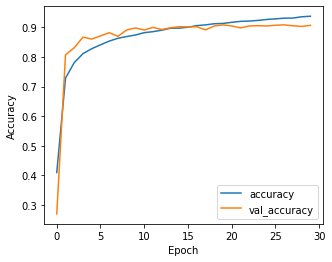

In [35]:
#Plot the accuracy
fig, ax = plt.subplots(1,1,figsize=(5,4))
PlotMetricsCNN(history_model_2, ax, 'accuracy', 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

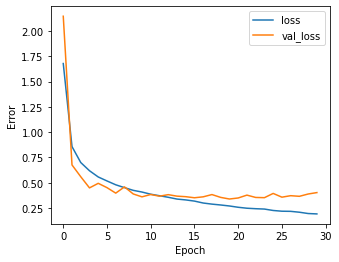

In [36]:
#Plot the loss
fig, ax = plt.subplots(1,1,figsize=(5,4))
PlotMetricsCNN(history_model_2, ax, 'loss', 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

**Observations:**
- This model makes use of regularization strategies such as batch normalization and dropout learning;
- The model is deeper than the previous one and uses more convolutional layers;
- Despite the fact that model_2 is deeper than model_1, it has less trainable parameters: this can be explained by the fact that more than one convolutional layer is used as well as pooling has been employed twice;
- The model shows a better preformance and the accuracy on the validation dataset is well balanced and close to the accuracy of the training dataset;
- The deeper network with additional convolutional layers has made the model more accurate but also more generalized;

## **Predictions on the test data**

In [38]:
#Make prediction on the test data using model_2 
test_pred = model_2.predict(X_test)

test_pred = np.argmax(test_pred, axis=-1)

In order to print the classification report and confusion matrix, each one-hot-encoded label is transformed back into single value.

In [48]:
#Converting each entry to single label from one-hot encoded vector
y_test_reconv = np.argmax(y_test, axis=-1)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1814
           1       0.91      0.91      0.91      1828
           2       0.93      0.92      0.92      1803
           3       0.85      0.87      0.86      1719
           4       0.94      0.91      0.92      1812
           5       0.87      0.92      0.89      1768
           6       0.91      0.89      0.90      1832
           7       0.95      0.92      0.93      1808
           8       0.88      0.89      0.89      1812
           9       0.91      0.89      0.90      1804

    accuracy                           0.91     18000
   macro avg       0.91      0.91      0.91     18000
weighted avg       0.91      0.91      0.91     18000



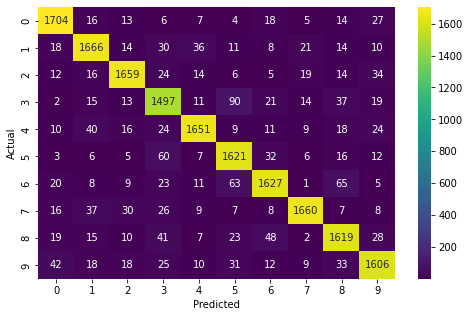

In [62]:
#importing required functions
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Printing the classification report
print(classification_report(y_test_reconv, test_pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_test_reconv, test_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', cmap='viridis')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### **Observations:**
- Two models were evaluated: a shallower model with 2 convolutional layer, and a deeper model with 4 convolutional layers;
- The deeper model ouperforms the shallower model a provides a more accurate prediction;
- The deeper model has a reduced overfitting and is sufficiently generalized;
- The deeper model has less trainable parameters because it has more convolutional layers;
- The smallest recall is around 90%;
- The confusion matrix provides low out-of-diagonal values, meaning that predictions are accurate and digit confusions (mistaking a 5 for a 6) is low in the CNN;
